<a href="https://colab.research.google.com/github/marcinwolter/Machine-learning-KISD-2022-projects/blob/main/BDT_Faces_MGiza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**My function for the Classifier and Faces classification:**

In [ ]:
from time import time
import logging
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA


from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pylab import figure, cm

from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

#def func(clf = KNeighborsClassifier(10), n_components = 8, plot = False, printing = True):


def func(max_depth=1, n_estimators=3000, n_components = 8, plot = False, printing = False):
  
  

  if printing:
    print(__doc__)

  # Display progress logs on stdout
    logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


  # #############################################################################
  # Download the data, if not already on disk and load it as numpy arrays

  lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

  # introspect the images arrays to find the shapes (for plotting)
  n_samples, h, w = lfw_people.images.shape

  # for machine learning we use the 2 data directly (as relative pixel
  # positions info is ignored by this model)
  X = lfw_people.data
  n_features = X.shape[1]

  # the label to predict is the id of the person
  y = lfw_people.target
  target_names = lfw_people.target_names
  n_classes = target_names.shape[0]

  if printing:
    print("Total dataset size:")
    print("n_samples: %d" % n_samples)
    print("n_features: %d" % n_features)
    print("n_classes: %d" % n_classes)


  # #############################################################################
  # Split into a training set and a test set using a stratified k fold

  # split into a training and testing set
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.25, random_state=42)


  # #############################################################################
  # Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
  # dataset): unsupervised feature extraction / dimensionality reduction

  # number of PCA components
  #n_components = 8 #32  
  
  if printing:
    print("Extracting the top %d eigenfaces from %d faces"
        % (n_components, X_train.shape[0]))
  t0 = time()
  pca = PCA(n_components=n_components, svd_solver='randomized',
            whiten=True).fit(X_train)
  if printing:          
    print("done in %0.3fs" % (time() - t0))

  eigenfaces = pca.components_.reshape((n_components, h, w))
  if printing:
    print("Projecting the input data on the eigenfaces orthonormal basis")
  t0 = time()
  X_train_pca = pca.transform(X_train)
  X_test_pca = pca.transform(X_test)
  if printing:
    print("done in %0.3fs" % (time() - t0))


  # #############################################################################
  # Train the classification model
  if printing:
    print("Fitting the classifier to the training set")
  t0 = time()

  #clf = KNeighborsClassifier(10)
  #clf = GaussianNB()
  #clf = LinearDiscriminantAnalysis()
  #clf = DecisionTreeClassifier(max_depth=5)
  clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = max_depth),n_estimators = n_estimators)



  # Fit the classifier
  clf = clf.fit(X_train_pca, y_train)


  '''
  # Optimize the KNeighborsClassifier
  clf = KNeighborsClassifier()
  # grid of n_neighbours to be tested
  param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 8, 10, 15, 20, 30, 40, 50, 100], }
  clf = GridSearchCV(clf,param_grid,cv=2)
  clf = clf.fit(X_train_pca, y_train)
  # This value gives the best performance
  print('Best params: ',clf.best_params_)
  '''
  if printing:
    print("done in %0.3fs" % (time() - t0))




  # #############################################################################
  # Quantitative evaluation of the model quality on the test set
  if printing:
    print("Predicting people's names on the test set")
  t0 = time()
  y_pred = clf.predict(X_test_pca)


  report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
  if printing:
    print(classification_report(y_test, y_pred, target_names=target_names))
    print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


  # define a funtion to plot the gallery

  def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
      """Helper function to plot a gallery of portraits"""
      plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
      plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
      for i in range(min(n_row * n_col, len(images))):
          plt.subplot(n_row, n_col, i + 1)
          plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
          plt.title(titles[i], size=12)
          plt.xticks(())
          plt.yticks(())




  # #############################################################################
  # Qualitative evaluation of the predictions using matplotlib
  # plot the result of the prediction on a portion of the test set

  def title(y_pred, y_test, target_names, i):
      pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
      true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
      return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

  prediction_titles = [title(y_pred, y_test, target_names, i)
                      for i in range(y_pred.shape[0])]
  if plot:                    
    print("plot_gallery")
    plot_gallery(X_test, prediction_titles, h, w)
    plt.show()


   # plot PCA reconstructed faces
    print("The PCA reconstructed faces")
    plot_gallery(pca.inverse_transform(X_test_pca), prediction_titles, h, w)
    plt.show()

  # plot the gallery of the most significative eigenfaces
    print("The most significative eigenfaces")
    eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
    plot_gallery(eigenfaces, eigenface_titles, h, w, int(eigenfaces.shape[0] / 4)+1, 4)
    plt.show()



  return report['macro avg']['precision'] 

I'm examining the parameter space around the arbitrarly chosen "good-enough" result of max_depth=5, n_components=20

**Plotting avg precision for different nb of estimators:**

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

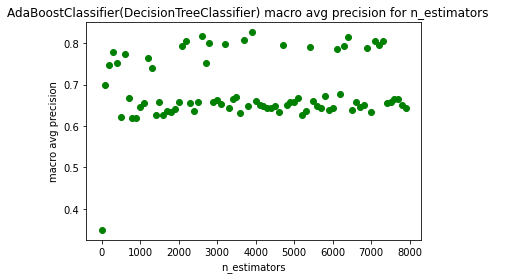

In [ ]:
for i in range(1, 8000, 100):
  rep_test = func(max_depth=5,n_estimators=i, n_components = 20, printing = False)
  plt.plot(i, rep_test, color='green', linestyle='solid', linewidth = 3, 
         marker='o')
  
  
plt.title('AdaBoostClassifier(DecisionTreeClassifier) macro avg precision for n_estimators   ')  
plt.xlabel('n_estimators')
plt.ylabel('macro avg precision')
plt.show()    

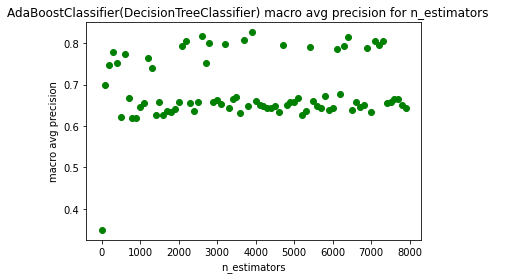

Choosing n_estimators = 3000

**Plotting avg precision for different max_depth:**

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

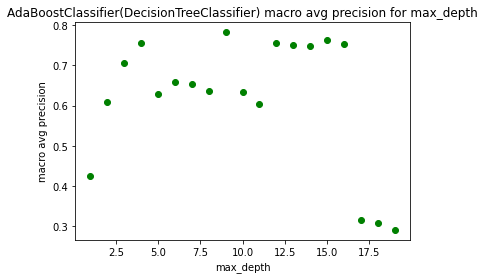

In [ ]:
for i in range(1, 20, 1):
  rep_test = func(max_depth=i,n_estimators=3000, n_components = 20, printing = False)
  plt.plot(i, rep_test, color='green', linestyle='solid', linewidth = 3, marker='o')
  
  
plt.title('AdaBoostClassifier(DecisionTreeClassifier) macro avg precision for max_depth')  
plt.xlabel('max_depth')
plt.ylabel('macro avg precision')
plt.show()  

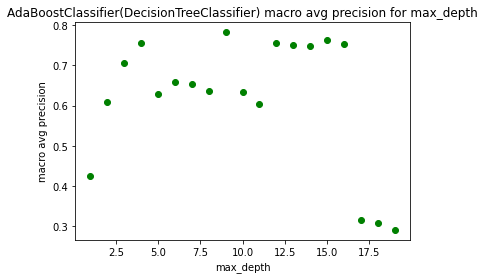

Choosing max_depth = 13 (quite stable neighbourhood)

**Plotting avg precision for different n_components:**

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

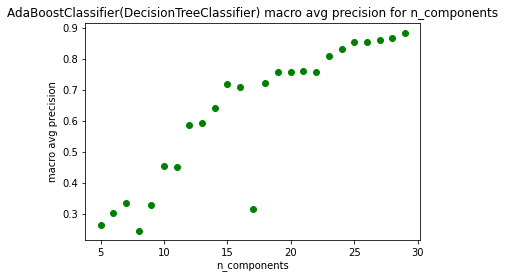

In [ ]:
for i in range(5, 30, 1):
  rep_test = func(max_depth=13,n_estimators=3000, n_components = i, printing = False)
  plt.plot(i, rep_test, color='green', linestyle='solid', linewidth = 3, marker='o')
  
  
plt.title('AdaBoostClassifier(DecisionTreeClassifier) macro avg precision for n_components')  
plt.xlabel('n_components')
plt.ylabel('macro avg precision')
plt.show()  

Plot for max_depth = 1

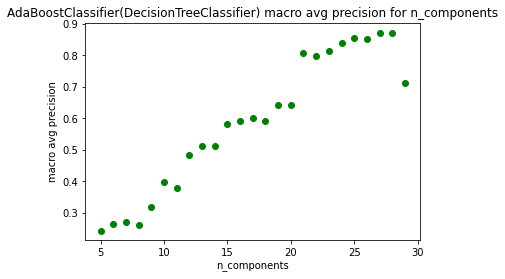

Plot for max_depth = 13

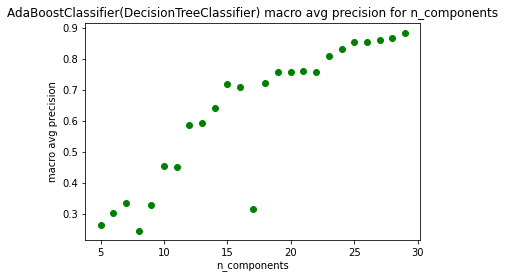

**The best result:**

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 29 eigenfaces from 966 faces
done in 0.182s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.030s
Fitting the classifier to the training set
done in 86.885s
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.08      0.14        13
     Colin Powell       0.88      0.73      0.80        60
  Donald Rumsfeld       0.71      0.19      0.29        27
    George W Bush       0.61      0.99      0.76       146
Gerhard Schroeder       1.00      0.32      0.48        25
      Hugo Chavez       1.00      0.07      0.12        15
       Tony Blair       0.83      0.42      0.56        36

         accuracy                           0.68       322
        macro avg       0.86      0.40      0.45       322
     weighted avg       0.76      0.

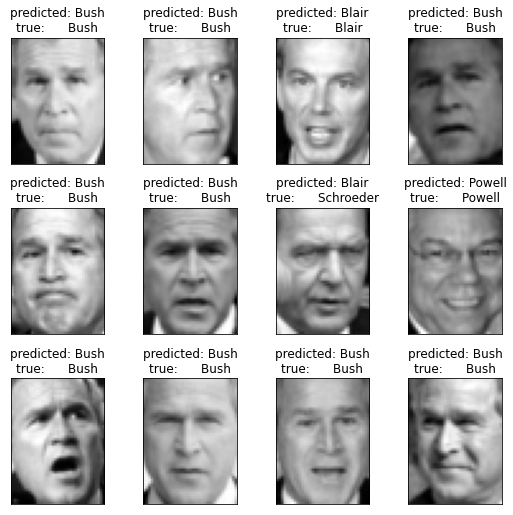

The PCA reconstructed faces


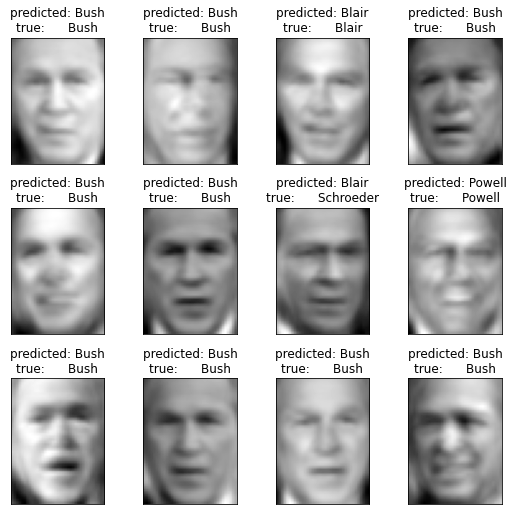

The most significative eigenfaces


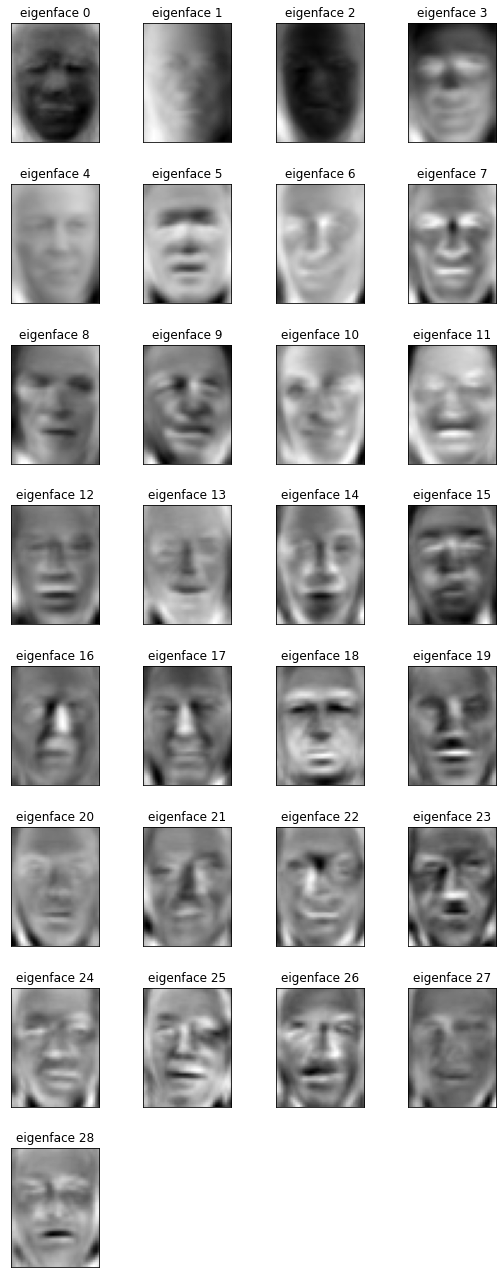

In [ ]:
rep_test = func(max_depth=13,n_estimators=3000, n_components = 29, plot = True, printing = True)

**ADDITIONAL TESTS ARE HERE:**

DecisionTreeClassifier(max_depth=1),n_estimators=6000

In [ ]:
func(clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=6000), n_components = 8)

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 8 eigenfaces from 966 faces
done in 0.082s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.010s
Fitting the classifier to the training set
done in 17.779s
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.11      0.23      0.15        13
     Colin Powell       0.29      0.13      0.18        60
  Donald Rumsfeld       0.09      0.11      0.10        27
    George W Bush       0.49      0.23      0.32       146
Gerhard Schroeder       0.10      0.28      0.15        25
      Hugo Chavez       0.03      0.07      0.04        15
       Tony Blair       0.20      0.33      0.25        36

         accuracy                           0.21       322
        macro avg       0.19      0.20      0.17       322
     weighted avg       0.32      0.2

DecisionTreeClassifier(max_depth=5),n_estimators=600

In [ ]:
func(clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=600), n_components = 8)

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 8 eigenfaces from 966 faces
done in 0.159s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.040s
Fitting the classifier to the training set
done in 4.216s
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.44      0.60      0.51        60
  Donald Rumsfeld       0.43      0.22      0.29        27
    George W Bush       0.58      0.79      0.67       146
Gerhard Schroeder       0.00      0.00      0.00        25
      Hugo Chavez       0.17      0.07      0.10        15
       Tony Blair       0.24      0.11      0.15        36

         accuracy                           0.51       322
        macro avg       0.27      0.26      0.25       322
     weighted avg       0.42      0.51

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=600), n_components = 12

In [ ]:
func(clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=600), n_components = 12)

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 12 eigenfaces from 966 faces
done in 0.326s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.035s
Fitting the classifier to the training set
done in 4.978s
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.33      0.08      0.12        13
     Colin Powell       0.52      0.55      0.54        60
  Donald Rumsfeld       0.53      0.30      0.38        27
    George W Bush       0.61      0.85      0.71       146
Gerhard Schroeder       0.42      0.20      0.27        25
      Hugo Chavez       0.00      0.00      0.00        15
       Tony Blair       0.36      0.25      0.30        36

         accuracy                           0.56       322
        macro avg       0.40      0.32      0.33       322
     weighted avg       0.51      0.5

func3(clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=600), n_components = 8)

In [ ]:
func(clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=600), n_components = 8)

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 8 eigenfaces from 966 faces
done in 0.146s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.016s
Fitting the classifier to the training set
done in 6.510s
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.41      0.52      0.46        60
  Donald Rumsfeld       0.25      0.11      0.15        27
    George W Bush       0.57      0.86      0.69       146
Gerhard Schroeder       0.00      0.00      0.00        25
      Hugo Chavez       0.00      0.00      0.00        15
       Tony Blair       0.50      0.14      0.22        36

         accuracy                           0.51       322
        macro avg       0.25      0.23      0.22       322
     weighted avg       0.41      0.51

func3(clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=6000), n_components = 8)

In [ ]:
func(clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=6000), n_components = 8)

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 8 eigenfaces from 966 faces
done in 0.171s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.022s
Fitting the classifier to the training set
done in 55.911s
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.46      0.52      0.48        60
  Donald Rumsfeld       0.25      0.11      0.15        27
    George W Bush       0.56      0.86      0.68       146
Gerhard Schroeder       0.00      0.00      0.00        25
      Hugo Chavez       0.00      0.00      0.00        15
       Tony Blair       0.50      0.17      0.25        36

         accuracy                           0.52       322
        macro avg       0.25      0.24      0.22       322
     weighted avg       0.41      0.5

func(clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=600), n_components = 12)

In [ ]:
func(clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=600), n_components = 12)

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 12 eigenfaces from 966 faces
done in 0.125s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.016s
Fitting the classifier to the training set
done in 9.780s
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.08      0.14        13
     Colin Powell       0.59      0.55      0.57        60
  Donald Rumsfeld       0.46      0.22      0.30        27
    George W Bush       0.60      0.91      0.72       146
Gerhard Schroeder       0.44      0.16      0.24        25
      Hugo Chavez       0.50      0.07      0.12        15
       Tony Blair       0.50      0.28      0.36        36

         accuracy                           0.58       322
        macro avg       0.59      0.32      0.35       322
     weighted avg       0.58      0.5

func(clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=6000), n_components = 15)

In [ ]:
func(clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=6000), n_components = 15)

2022-03-13 09:49:17,267 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012


Automatically created module for IPython interactive environment


2022-03-13 09:49:18,640 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2022-03-13 09:49:19,932 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2022-03-13 09:49:21,517 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 15 eigenfaces from 966 faces
done in 0.124s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.015s
Fitting the classifier to the training set
done in 85.382s
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.69      0.57      0.62        60
  Donald Rumsfeld       0.67      0.30      0.41        27
    George W Bush       0.59      0.93      0.72       146
Gerhard Schroeder       0.75      0.12      0.21        25
      Hugo Chavez       1.00      0.13      0.24        15
       Tony Blair       0.38      0.25      0.30        36

         accuracy                           0.60       322
        macro avg       0.58      0.33      0.36       322
     weighted avg       0.60      0.60      0.54       322

[[  0   6   2   5   0   0   0]
 [  0  34 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


BaggingClassifier(DecisionTreeClassifier(max_depth=5), max_samples=100, n_estimators=100)

In [ ]:
func(clf = BaggingClassifier(DecisionTreeClassifier(max_depth=5), max_samples=100, n_estimators=100), n_components = 8)

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 8 eigenfaces from 966 faces
done in 0.122s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.017s
Fitting the classifier to the training set
done in 0.472s
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.40      0.42      0.41        60
  Donald Rumsfeld       0.25      0.04      0.06        27
    George W Bush       0.54      0.92      0.68       146
Gerhard Schroeder       0.00      0.00      0.00        25
      Hugo Chavez       0.00      0.00      0.00        15
       Tony Blair       0.50      0.06      0.10        36

         accuracy                           0.51       322
        macro avg       0.24      0.20      0.18       322
     weighted avg       0.40      0.51

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AdaBoostClassifier(learning_rate=2.5,base_estimator=GaussianNB(),n_estimators=500,algorithm='SAMME.R')

In [ ]:
func(clf = AdaBoostClassifier(learning_rate=2.5,base_estimator=GaussianNB(),n_estimators=500,algorithm='SAMME.R'), n_components = 8)

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 8 eigenfaces from 966 faces
done in 0.145s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.020s
Fitting the classifier to the training set
done in 3.645s
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.15      0.15      0.15        13
     Colin Powell       0.31      0.28      0.30        60
  Donald Rumsfeld       0.11      0.07      0.09        27
    George W Bush       0.53      0.68      0.60       146
Gerhard Schroeder       0.25      0.04      0.07        25
      Hugo Chavez       0.14      0.20      0.17        15
       Tony Blair       0.12      0.08      0.10        36

         accuracy                           0.40       322
        macro avg       0.23      0.22      0.21       322
     weighted avg       0.36      0.40

BaggingClassifier(KNeighborsClassifier(n_neighbors=3),n_estimators=500)

In [ ]:
func(clf = BaggingClassifier(KNeighborsClassifier(n_neighbors=3),n_estimators=500), n_components = 8)

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 8 eigenfaces from 966 faces
done in 0.146s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.018s
Fitting the classifier to the training set
done in 1.843s
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.20      0.23      0.21        13
     Colin Powell       0.39      0.45      0.42        60
  Donald Rumsfeld       0.41      0.48      0.44        27
    George W Bush       0.63      0.66      0.65       146
Gerhard Schroeder       0.15      0.08      0.11        25
      Hugo Chavez       0.09      0.07      0.08        15
       Tony Blair       0.36      0.28      0.31        36

         accuracy                           0.48       322
        macro avg       0.32      0.32      0.32       322
     weighted avg       0.46      0.48

BaggingClassifier(LinearDiscriminantAnalysis(),max_samples=8,n_estimators=100)

In [ ]:
func(clf = BaggingClassifier(LinearDiscriminantAnalysis(),max_samples=8,n_estimators=100), n_components = 8)

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 8 eigenfaces from 966 faces
done in 0.100s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.017s
Fitting the classifier to the training set
done in 0.362s
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.67      0.03      0.06        60
  Donald Rumsfeld       0.00      0.00      0.00        27
    George W Bush       0.46      1.00      0.63       146
Gerhard Schroeder       0.00      0.00      0.00        25
      Hugo Chavez       0.00      0.00      0.00        15
       Tony Blair       0.00      0.00      0.00        36

         accuracy                           0.46       322
        macro avg       0.16      0.15      0.10       322
     weighted avg       0.33      0.46

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


BaggingClassifier(LinearDiscriminantAnalysis(),max_samples=8,n_estimators=100)

In [ ]:
func(clf = BaggingClassifier(LinearDiscriminantAnalysis(),max_samples=8,n_estimators=100), n_components = 8)

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 8 eigenfaces from 966 faces
done in 0.238s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.037s
Fitting the classifier to the training set
done in 0.413s
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.80      0.07      0.12        60
  Donald Rumsfeld       0.00      0.00      0.00        27
    George W Bush       0.46      1.00      0.63       146
Gerhard Schroeder       0.00      0.00      0.00        25
      Hugo Chavez       0.00      0.00      0.00        15
       Tony Blair       0.00      0.00      0.00        36

         accuracy                           0.47       322
        macro avg       0.18      0.15      0.11       322
     weighted avg       0.36      0.47

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
